# Squeezenet train on AWA2

Ensure any edits to libraries are reloaded here automatically. Use `matplotlib inline` to display any charts or images inline in the notebook.

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import fastai packages. Use [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions which enable quick and easy building of neural networks and training models.

In [4]:
from fastai import *
from fastai.vision import *

Import [squeezenet1_1](https://pytorch.org/docs/stable/torchvision/models.html#id4) from pytorch `torchvision.models`. SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters than SqueezeNet 1.0, without sacrificing accuracy.

In [5]:
from torchvision.models import squeezenet1_1

Batchsize is critical when training models. On my system (gpu: GTX 1080 ti, ram: 2*16 GB) with bs = 32, it would quickly run out of memory!

In [6]:
bs = 16

## Loading AWA2 dataset

AWA2 (Animals with Attributes) is a benchmark dataset for transfer learning algorithms such as zero-shot learning. It consists of 37322 images of 50 animals and size of AwA2-data.zip is 13GB! The images in the dataset are in JPEG format.

I downloaded and extracted the dataset on my system. It took a total of 10 hours to download the entire data! 
The data is in the following format:
```
path/
    JPEGImages\
        antelope\
            antelope_10001.jpg
            antelope_10002.jpg
            ...
        bobcat\
            bobcat_10001.jpg
            bobcat_10002.jpg
            ...
        .
        .
        .
        classes.txt
```
classes.txt contains names of all the 50 animal categories, one per line.

I am currently training on a subset of AwA2 to speedup the process. I have selected 15 classes - `'beaver', 'killer+whale', 'horse', 'dalmatian', 'german+shepherd', 'mole', 'hippopotamus', 'antelope', 'grizzly+bear', 'siamese+cat', 'leopard', 'blue+whale', 'skunk', 'tiger', 'persian+cat'` - with 300 images in each class. Train / dev split is 90 : 10.

In [7]:
path = Path(f'/home/nik/data/Animals_with_Attributes2_small'); path

PosixPath('/home/nik/data/Animals_with_Attributes2_small')

In [8]:
path.ls()

[PosixPath('/home/nik/data/Animals_with_Attributes2_small/models'),
 PosixPath('/home/nik/data/Animals_with_Attributes2_small/train'),
 PosixPath('/home/nik/data/Animals_with_Attributes2_small/valid')]

## Dataloader and Data Augmentation

Fastai provides convenience methods to create `DataBunch` objects which can be used for training a classifier.

With `get_transforms()`, fastai applies a bunch of transforms (pixel and co-ordinate - flip, rotate, warp, zoom, lighting transforms) in an optimized way. The `get_transforms()` function returns a tuple of two list of transforms, one for the training set and the other for the validation set(limited to center crop by default).

In [9]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=224, bs=bs)
data.normalize(imagenet_stats)

To take a peek at the images inside a batch, use `ImageDataBunch.show_batch`, _rows_ argument indicates number of rows and columns to display.

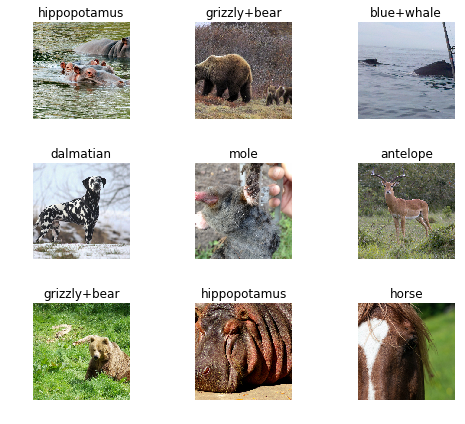

In [10]:
data.show_batch(rows=3, figsize=(7,6))

In [11]:
print(data.classes)
len(data.classes),data.c # data.c contains the number of classes of the data

['beaver', 'killer+whale', 'horse', 'dalmatian', 'german+shepherd', 'mole', 'hippopotamus', 'antelope', 'grizzly+bear', 'siamese+cat', 'leopard', 'blue+whale', 'skunk', 'tiger', 'persian+cat']


(15, 15)

## Model Training: squeezenet1_1

Fastai uses [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. The idea here is the model will take images as input and will output the predicted probability for each of the 15 categories.

This method creates a `Learner` object from the passed `DataBunch` object and backbone provided in the `arch`. It also cuts the model defined by `arch`(pretrained on Imagenet) at the last convolutional layer by default.

I am training for 4 epochs (4 cycles through all our data) with valid_loss at 0.285246 and accuracy 91.56%.

In [12]:
learn = create_cnn(data, squeezenet1_1, metrics=error_rate)

In [13]:
learn.fit_one_cycle(4)

Total time: 03:40
epoch  train_loss  valid_loss  error_rate
1      0.753402    0.439968    0.140000    (00:54)
2      0.565148    0.412945    0.137778    (00:55)
3      0.434568    0.300514    0.091111    (00:55)
4      0.331909    0.285246    0.084444    (00:54)



## Saving the model

In [14]:
learn.save('stage-1')

## Results

`from_learner` is a factory method to instantiate `ClassificationInterpretation` which provides a confusion matrix and visualization for misclassified images. It uses the dev set and does not do any test time augmentation by default.

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

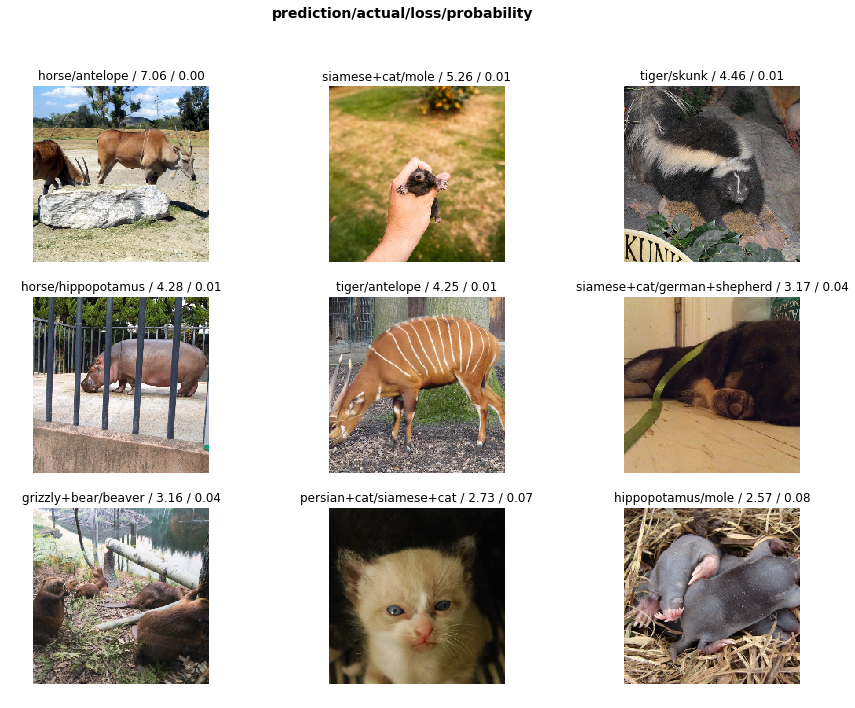

In [16]:
interp.plot_top_losses(9, figsize=(15,11))

Plotting the confusion matrix helps identify which categories were confused with other categories and how often!

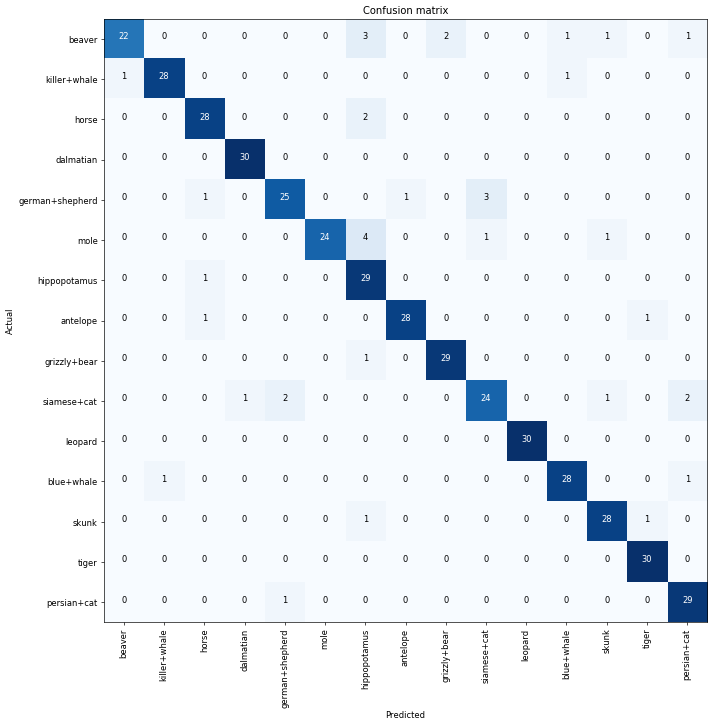

In [17]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [18]:
interp.most_confused(min_val=2)

[('mole', 'hippopotamus', 4),
 ('beaver', 'hippopotamus', 3),
 ('german+shepherd', 'siamese+cat', 3)]

## Unfreezing and fine-tuning

*unfreeze* the model and train some more.

In [19]:
learn.unfreeze()

In [20]:
learn.fit_one_cycle(1)

Total time: 01:34
epoch  train_loss  valid_loss  error_rate
1      2.220366    1.814008    0.580000    (01:34)



In [21]:
learn.load('stage-1')

ClassificationLearner(data=<fastai.vision.data.ImageDataBunch object at 0x7f5b18ca6710>, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace)
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace)
        (expand3x3): Conv2d(16, 64, kernel_size

## Selecting Learning Rate

In [22]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


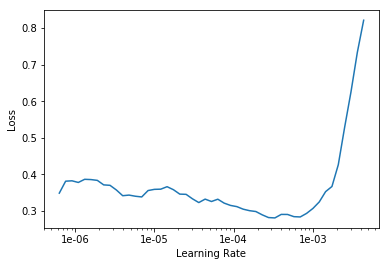

In [23]:
learn.recorder.plot()

In [24]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 03:11
epoch  train_loss  valid_loss  error_rate
1      0.337175    0.263562    0.071111    (01:34)
2      0.284486    0.264998    0.073333    (01:37)



Model Accuracy is 92.67%